## CartPole Skating

> **Problema**: Kung nais ni Peter na makatakas mula sa lobo, kailangan niyang makagalaw nang mas mabilis kaysa rito. Titingnan natin kung paano matututo si Peter na mag-skate, partikular na panatilihin ang balanse, gamit ang Q-Learning.

Una, mag-install tayo ng gym at i-import ang mga kinakailangang library:


In [1]:
import sys
!pip install gym 

import gym
import matplotlib.pyplot as plt
import numpy as np
import random

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


## Gumawa ng kapaligiran ng cartpole


In [2]:
env = gym.make("CartPole-v1")
print(env.action_space)
print(env.observation_space)
print(env.action_space.sample())

Discrete(2)
Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
0


Upang makita kung paano gumagana ang kapaligiran, magpatakbo tayo ng maikling simulasyon para sa 100 hakbang.


In [3]:
env.reset()

for i in range(100):
   env.render()
   env.step(env.action_space.sample())
env.close()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Sa panahon ng simulasyon, kailangan nating makakuha ng mga obserbasyon upang makapagdesisyon kung paano kumilos. Sa katunayan, ang `step` na function ay nagbabalik sa atin ng kasalukuyang mga obserbasyon, reward function, at ang `done` na flag na nagpapahiwatig kung may saysay pa bang ipagpatuloy ang simulasyon o hindi:


In [4]:
env.reset()

done = False
while not done:
   env.render()
   obs, rew, done, info = env.step(env.action_space.sample())
   print(f"{obs} -> {rew}")
env.close()

[ 0.03044442 -0.19543914 -0.04496216  0.28125618] -> 1.0
[ 0.02653564 -0.38989186 -0.03933704  0.55942606] -> 1.0
[ 0.0187378  -0.19424049 -0.02814852  0.25461393] -> 1.0
[ 0.01485299 -0.38894946 -0.02305624  0.53828712] -> 1.0
[ 0.007074   -0.19351108 -0.0122905   0.23842953] -> 1.0
[ 0.00320378  0.00178427 -0.00752191 -0.05810469] -> 1.0
[ 0.00323946  0.19701326 -0.008684   -0.35315131] -> 1.0
[ 0.00717973  0.00201587 -0.01574703 -0.06321931] -> 1.0
[ 0.00722005  0.19736001 -0.01701141 -0.36082863] -> 1.0
[ 0.01116725  0.39271958 -0.02422798 -0.65882671] -> 1.0
[ 0.01902164  0.19794307 -0.03740452 -0.37387001] -> 1.0
[ 0.0229805   0.39357584 -0.04488192 -0.67810827] -> 1.0
[ 0.03085202  0.58929164 -0.05844408 -0.98457719] -> 1.0
[ 0.04263785  0.78514572 -0.07813563 -1.2950295 ] -> 1.0
[ 0.05834076  0.98116859 -0.10403622 -1.61111521] -> 1.0
[ 0.07796413  0.78741784 -0.13625852 -1.35259196] -> 1.0
[ 0.09371249  0.98396202 -0.16331036 -1.68461179] -> 1.0
[ 0.11339173  0.79106371 -0.197

Makukuha natin ang pinakamaliit at pinakamalaking halaga ng mga numerong iyon:


In [5]:
print(env.observation_space.low)
print(env.observation_space.high)

[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


In [6]:
def discretize(x):
    return tuple((x/np.array([0.25, 0.25, 0.01, 0.1])).astype(np.int))

Tuklasin din natin ang iba pang paraan ng discretization gamit ang mga bins:


In [7]:
def create_bins(i,num):
    return np.arange(num+1)*(i[1]-i[0])/num+i[0]

print("Sample bins for interval (-5,5) with 10 bins\n",create_bins((-5,5),10))

ints = [(-5,5),(-2,2),(-0.5,0.5),(-2,2)] # intervals of values for each parameter
nbins = [20,20,10,10] # number of bins for each parameter
bins = [create_bins(ints[i],nbins[i]) for i in range(4)]

def discretize_bins(x):
    return tuple(np.digitize(x[i],bins[i]) for i in range(4))

Sample bins for interval (-5,5) with 10 bins
 [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


Ngayon, magpatakbo tayo ng maikling pagsubok at obserbahan ang mga hiwalay na halaga ng kapaligiran.


In [8]:
env.reset()

done = False
while not done:
   #env.render()
   obs, rew, done, info = env.step(env.action_space.sample())
   #print(discretize_bins(obs))
   print(discretize(obs))
env.close()

(0, 0, -1, -3)
(0, 0, -2, 0)
(0, 0, -2, -3)
(0, 1, -3, -6)
(0, 2, -4, -9)
(0, 3, -6, -12)
(0, 2, -8, -9)
(0, 3, -10, -13)
(0, 4, -13, -16)
(0, 4, -16, -19)
(0, 4, -20, -17)
(0, 4, -24, -20)


In [9]:
Q = {}
actions = (0,1)

def qvalues(state):
    return [Q.get((state,a),0) for a in actions]

In [10]:
# hyperparameters
alpha = 0.3
gamma = 0.9
epsilon = 0.90

In [11]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Qmax = 0
cum_rewards = []
rewards = []
for epoch in range(100000):
    obs = env.reset()
    done = False
    cum_reward=0
    # == do the simulation ==
    while not done:
        s = discretize(obs)
        if random.random()<epsilon:
            # exploitation - chose the action according to Q-Table probabilities
            v = probs(np.array(qvalues(s)))
            a = random.choices(actions,weights=v)[0]
        else:
            # exploration - randomly chose the action
            a = np.random.randint(env.action_space.n)

        obs, rew, done, info = env.step(a)
        cum_reward+=rew
        ns = discretize(obs)
        Q[(s,a)] = (1 - alpha) * Q.get((s,a),0) + alpha * (rew + gamma * max(qvalues(ns)))
    cum_rewards.append(cum_reward)
    rewards.append(cum_reward)
    # == Periodically print results and calculate average reward ==
    if epoch%5000==0:
        print(f"{epoch}: {np.average(cum_rewards)}, alpha={alpha}, epsilon={epsilon}")
        if np.average(cum_rewards) > Qmax:
            Qmax = np.average(cum_rewards)
            Qbest = Q
        cum_rewards=[]

0: 108.0, alpha=0.3, epsilon=0.9


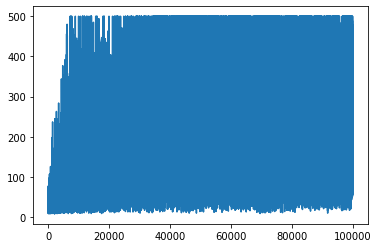

In [20]:
plt.plot(rewards)

Mula sa graph na ito, hindi posible na malaman ang anumang bagay, dahil sa likas na katangian ng stochastic na proseso ng pagsasanay, ang haba ng mga sesyon ng pagsasanay ay lubos na nagkakaiba. Upang mas magkaroon ng kahulugan ang graph na ito, maaari nating kalkulahin ang **running average** sa serye ng mga eksperimento, halimbawa 100. Magagawa ito nang madali gamit ang `np.convolve`:


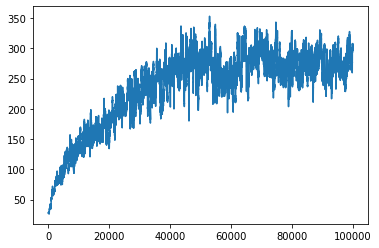

In [22]:
def running_average(x,window):
    return np.convolve(x,np.ones(window)/window,mode='valid')

plt.plot(running_average(rewards,100))

## Pag-iiba-iba ng mga Hyperparameter at Pagtingin sa Resulta sa Aksyon

Ngayon, magiging interesante na makita kung paano talaga gumagana ang na-train na modelo. Patakbuhin natin ang simulation, at susundin natin ang parehong estratehiya sa pagpili ng aksyon tulad noong training: pag-sample batay sa probability distribution sa Q-Table:


In [23]:
obs = env.reset()
done = False
while not done:
   s = discretize(obs)
   env.render()
   v = probs(np.array(qvalues(s)))
   a = random.choices(actions,weights=v)[0]
   obs,_,done,_ = env.step(a)
env.close()

## Pag-save ng resulta sa isang animated GIF

Kung nais mong magpasikat sa iyong mga kaibigan, maaari mong ipadala sa kanila ang animated GIF na larawan ng balancing pole. Para gawin ito, maaari nating gamitin ang `env.render` upang makagawa ng isang frame ng imahe, at pagkatapos ay i-save ang mga ito bilang animated GIF gamit ang PIL library:


In [26]:
from PIL import Image
obs = env.reset()
done = False
i=0
ims = []
while not done:
   s = discretize(obs)
   img=env.render(mode='rgb_array')
   ims.append(Image.fromarray(img))
   v = probs(np.array([Qbest.get((s,a),0) for a in actions]))
   a = random.choices(actions,weights=v)[0]
   obs,_,done,_ = env.step(a)
   i+=1
env.close()
ims[0].save('images/cartpole-balance.gif',save_all=True,append_images=ims[1::2],loop=0,duration=5)
print(i)

360



---

**Paunawa**:  
Ang dokumentong ito ay isinalin gamit ang AI translation service na [Co-op Translator](https://github.com/Azure/co-op-translator). Bagama't sinisikap naming maging tumpak, tandaan na ang mga awtomatikong pagsasalin ay maaaring maglaman ng mga pagkakamali o hindi pagkakatugma. Ang orihinal na dokumento sa kanyang katutubong wika ang dapat ituring na opisyal na pinagmulan. Para sa mahalagang impormasyon, inirerekomenda ang propesyonal na pagsasalin ng tao. Hindi kami mananagot sa anumang hindi pagkakaunawaan o maling interpretasyon na dulot ng paggamit ng pagsasaling ito.
